In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from econml.policy import PolicyTree

In [16]:
import numpy as np

X = np.random.normal(size=(1000, 10))
y = np.hstack([X[:, [0]] > 0, X[:, [0]] < 0])

In [17]:
est = PolicyTree(min_impurity_decrease=.001, honest=False).fit(X, y)

In [18]:
est.feature_importances_

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
from sklearn.tree import plot_tree

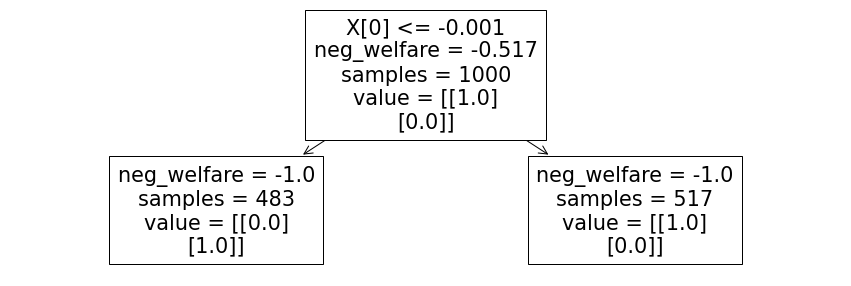

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plot_tree(est, max_depth=2)
plt.show()

In [21]:
from econml.policy import PolicyForest

est = PolicyForest().fit(X, y)

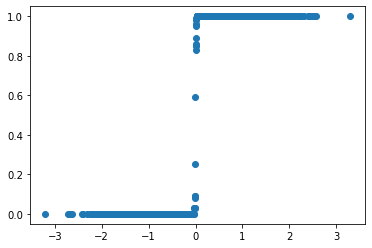

In [22]:
plt.scatter(X[:, 0], est.predict(X)[:, 0])
plt.show()

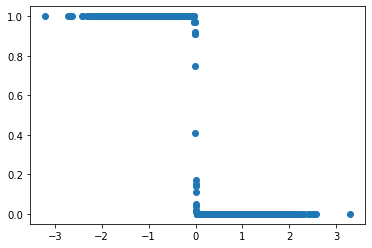

In [23]:
plt.scatter(X[:, 0], est.predict(X)[:, 1])
plt.show()

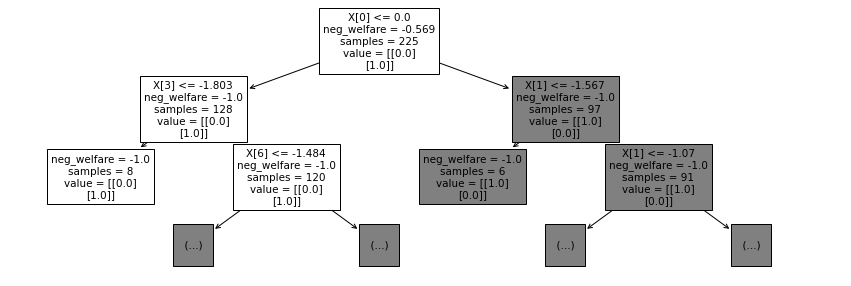

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plot_tree(est[0], max_depth=2)
plt.show()

In [25]:
est.feature_importances_

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [28]:
from econml.dml import LinearDML
est = LinearDML(linear_first_stages=False).fit(y, X[:, 0], X=X)

In [32]:
intrp = SingleTreePolicyInterpreter().interpret(est, X)

IndexError: index 1 is out of bounds for axis 0 with size 1

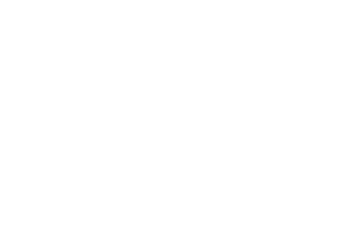

In [33]:
intrp.plot()

In [34]:
intrp.tree_model.tree_.value

array([[[0.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [1.]],

       [[0.],
        [0.],
        [1.]],

       ...,

       [[0.],
        [0.],
        [1.]],

       [[0.],
        [0.],
        [1.]],

       [[0.],
        [1.],
        [0.]]])